1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).
2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.
3. [опция]. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
# сгенерируем данные
classes = datasets.make_classification(n_samples=1000, n_features=2, n_informative=2, 
                                                      n_classes=2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

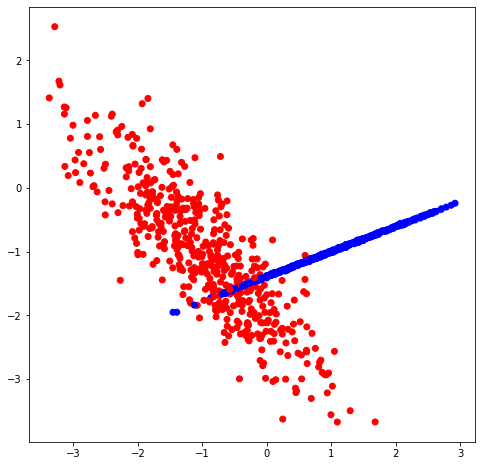

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classes[0])), list(map(lambda x: x[1], classes[0])), 
              c=classes[1], cmap=colors)

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    counter = 0
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        self.prediction_regressor = self.predict_regressor()
        type(self).counter += 1
        
    def predict_regressor(self):
        return np.mean(self.labels)
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [6]:
class DecisionTree():
    
    def __init__(self, max_depth=0, max_leaf=0, min_samples_leaf=1, criterion='gini'):
        self.max_depth = max_depth
        self.max_leaf = max_leaf
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        
    # Расчет критерия Джини

    def gini(self, labels):
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2

        return impurity
    
    def entropy(self, labels):
        classes = np.unique(labels)
        entropy = -sum([((labels == classes[i]).sum() / len(labels)) * \
                  np.log2((labels == classes[i]).sum() / len(labels)) \
                  for i in range(len(classes))])
        return entropy
    
    def quality_entropy(self, left_labels, right_labels, current_entropy):
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        return current_entropy - p * self.entropy(left_labels) - (1 - p) * self.entropy(right_labels)
    
    def quality(self, left_labels, right_labels, current_gini):

        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_gini - p * self.gini(left_labels) - (1 - p) * self.gini(right_labels)
    
        # Разбиение датасета в узле

    def split(self, data, labels, index, t):

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
#         # Построение дерева с помощью рекурсивной функции

    def build_tree(self, data, labels, ind=0):
        
        ind +=1

        quality, t, index = self.find_best_split(data, labels)
#         print(t)
        
        if len(labels) < self.min_samples_leaf * 2:
            return Leaf(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

#         проверяем количество листьев в дереве:
        if Leaf.counter == self.max_leaf - 1:
            return Leaf(data, labels)
        if Leaf.counter == self.max_leaf - 2:
            return Leaf(true_data, true_labels), Leaf(false_data, false_labels)
#         при долгих размышлениях я пришел к выводу, что использование
#         только этого критерия останова нецелесообразно или во всяком случае слишком малое его 
#         значение - можно не успеть выйти из первой рекурсии, а такой исход мне представляется
#         не очень веселым, т.к. у нас будет всего полдерева и при построении 
#         предикта алгоритм поломается сразу на корневом узле

        #  Проверяем глубину узла
        if ind == self.max_depth:
            return Leaf(true_data, true_labels), Leaf(false_data, false_labels)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels, ind)
        false_branch = self.build_tree(false_data, false_labels, ind)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)
    
    def pred_object(self, obj, node):
#         print(node.index, 1, node.true_branch.index, 2, node.false_branch.index)

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer
        i = node.index
        
        if obj[i] <= node.t:
            return self.pred_object(obj, node.true_branch)
        else:
            return self.pred_object(obj, node.false_branch)
        
    def predict(self, data, tree):

        pred = []
        for obj in data:
            prediction = self.pred_object(obj, tree)
            pred.append(prediction)
        return pred

In [7]:
class DecisionTreeClassifier(DecisionTree):
    
    # Расчет критерия Джини

    def gini(self, labels):
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2

        return impurity
    
    def entropy(self, labels):
        classes = np.unique(labels)
        entropy = -sum([((labels == classes[i]).sum() / len(labels)) * \
                  np.log2((labels == classes[i]).sum() / len(labels)) \
                  for i in range(len(classes))])
        return entropy
    
    def quality_entropy(self, left_labels, right_labels, current_entropy):
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        return current_entropy - p * self.entropy(left_labels) - (1 - p) * self.entropy(right_labels)
    
    def quality(self, left_labels, right_labels, current_gini):

        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_gini - p * self.gini(left_labels) - (1 - p) * self.gini(right_labels)
    
            # Нахождение наилучшего разбиения

    def find_best_split(self, data, labels):

        if self.criterion == 'gini':
            current_criterion = self.gini(labels)
        else:
            current_criterion = self.entropy(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_samples_leaf or len(false_data) < self.min_samples_leaf:
                    continue

                if self.criterion == 'gini':
                    current_quality = self.quality(true_labels, false_labels, current_criterion)
                else:
                    current_quality = self.quality_entropy(true_labels, false_labels, current_criterion)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index
#         print(best_index)
        return best_quality, best_t, best_index

In [39]:
class DecisionTreeRegressor(DecisionTree):
    
    def quality(self, left_labels, right_labels, current_var):
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        return current_var - p * np.var(left_labels) - (1 - p) * np.var(right_labels)
    
    def find_best_split(self, data, labels):
        
        current_criterion = np.var(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается объектов меньше, чем указано гиперпараметром
                if len(true_data) < self.min_samples_leaf or len(false_data) < self.min_samples_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, current_criterion)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index
    
    def pred_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction_regressor
            return answer
        i = node.index
        
        if obj[i] <= node.t:
            return self.pred_object(obj, node.true_branch)
        else:
            return self.pred_object(obj, node.false_branch)

# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_samples_leaf):
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index
    print(best_index)
    return best_quality, best_t, best_index

# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, min_samples_leaf=5):
    min_samples = min_samples_leaf

    quality, t, index = find_best_split(data, labels, min_samples)
#     print(t)
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [10]:
def train_test_split(data, proportion=0.7):
    # перемешивание датасета
    np.random.seed(12)
    shuffle_index = np.random.permutation(data[0].shape[0])
    X_shuffled, y_shuffled = data[0][shuffle_index], data[1][shuffle_index]

    # разбивка на обучающую и тестовую выборки
    train_proportion = proportion
    train_test_cut = int(len(data[0]) * train_proportion)

    X_train, X_test, y_train, y_test = \
        X_shuffled[:train_test_cut], \
        X_shuffled[train_test_cut:], \
        y_shuffled[:train_test_cut], \
        y_shuffled[train_test_cut:]
    list_array = [X_train, X_test, y_train, y_test]
    
#     X_train, X_test, y_train, y_test = transpose(list_array)

    print("Размер массива признаков обучающей выборки", X_train.shape)
    print("Размер массива признаков тестовой выборки", X_test.shape)
    print("Размер массива ответов для обучающей выборки", y_train.shape)
    print("Размер массива ответов для тестовой выборки", y_test.shape)
    
    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(classes)

Размер массива признаков обучающей выборки (700, 2)
Размер массива признаков тестовой выборки (300, 2)
Размер массива ответов для обучающей выборки (700,)
Размер массива ответов для тестовой выборки (300,)


In [12]:
tree = DecisionTreeClassifier(min_samples_leaf=4)
my_tree = tree.build_tree(X_train, y_train)

In [13]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог -0.001967524769128759
--> True:
  Индекс 1
  Порог -1.3993975578815423
  --> True:
    Индекс 1
    Порог -1.6727874248522925
    --> True:
      Индекс 0
      Порог -1.1987702734309238
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 0
    --> False:
      Индекс 0
      Порог -0.7166853207483512
      --> True:
        Прогноз: 0
      --> False:
        Индекс 0
        Порог -0.0974454796838633
        --> True:
          Индекс 1
          Порог -1.4255078037225668
          --> True:
            Индекс 1
            Порог -1.4639945887592973
            --> True:
              Индекс 0
              Порог -0.19169723851473508
              --> True:
                Индекс 0
                Порог -0.5543283463967666
                --> True:
                  Индекс 1
                  Порог -1.6177246767519375
                  --> True:
                    Прогноз: 1
                  --> False:
                    Прогноз: 0
                -

In [15]:
train_pred = tree.predict(X_train, my_tree)

In [16]:
test_pred = tree.predict(X_test, my_tree)

In [17]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [18]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(y_train, train_pred)
train_accuracy

98.28571428571429

In [19]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(y_test, test_pred)
test_accuracy

96.0

<ipython-input-24-5cb1f5d42ae5>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-24-5cb1f5d42ae5>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=96.00')

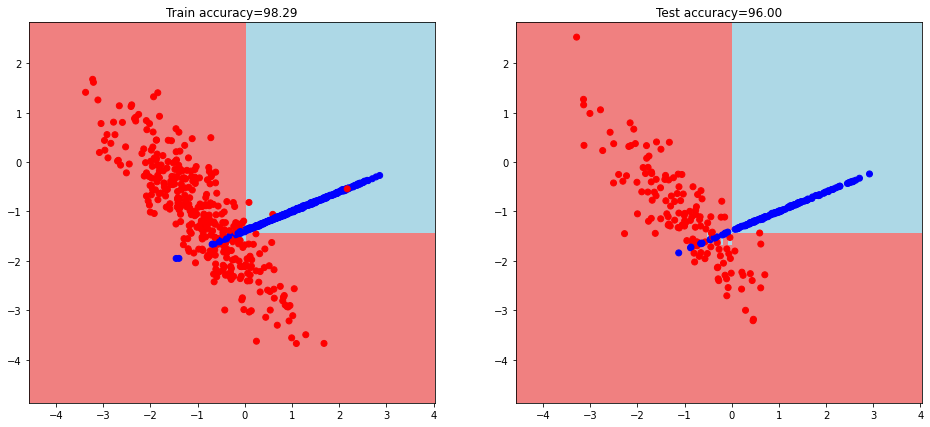

In [24]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(X_train)
mesh_predictions = np.array(tree.predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [25]:
# дерево с энтропийным критерием
tree = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=4)
my_tree = tree.build_tree(X_train, y_train)

In [26]:
train_pred = tree.predict(X_train, my_tree)
test_pred = tree.predict(X_test, my_tree)

In [27]:
train_accuracy = accuracy_metric(y_train, train_pred)

test_accuracy = accuracy_metric(y_test, test_pred)
train_accuracy, test_accuracy

(98.28571428571429, 95.66666666666667)

<ipython-input-28-37cf26f45492>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-28-37cf26f45492>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=95.67')

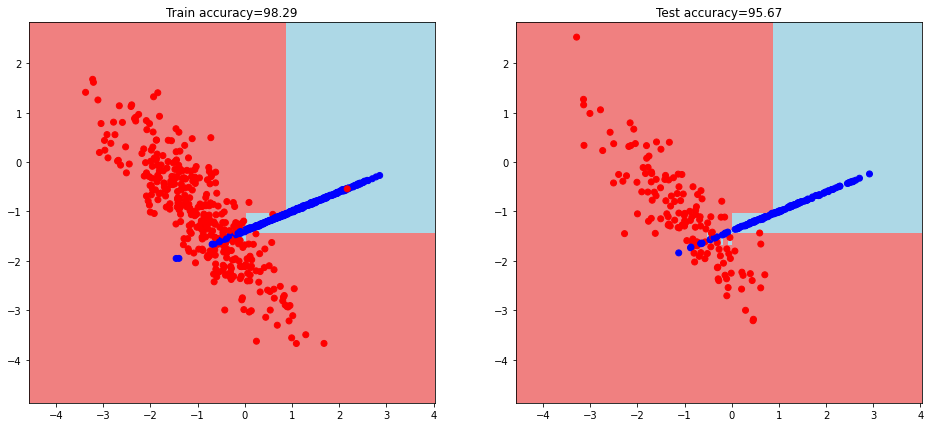

In [28]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(X_train)
mesh_predictions = np.array(tree.predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

на большое количество исследований времени не осталось - его съел дебаггинг кода (очень много ошибок почти на пустом месте повылазило)
по данному сравнению можно сделать вывод: по непонятной причине разделение гиперплоскости более, скажем так, детализированное при использовании энтропийного критерия, но при этом точность на отложенной выборке чуть выше.
    Но это не показатель - еще надо посмотреть как они себя поведут на данных посложней.

In [44]:
classes = datasets.make_regression(n_samples=1500, n_features=2,
                                    n_informative=2, n_targets=1,
                                    noise=5, coef=True, random_state=12)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(classes)

Размер массива признаков обучающей выборки (1050, 2)
Размер массива признаков тестовой выборки (450, 2)
Размер массива ответов для обучающей выборки (1050,)
Размер массива ответов для тестовой выборки (450,)


In [46]:
tree = DecisionTreeRegressor(min_samples_leaf=4)
my_tree = tree.build_tree(X_train, y_train)

In [37]:
def calc_mse(y, y_pred):
    return np.mean(y - y_pred) ** 2

In [47]:
train_pred = tree.predict(X_train, my_tree)
test_pred = tree.predict(X_test, my_tree)

In [48]:
train_mse = calc_mse(y_train, train_pred)
test_mse = calc_mse(y_test, test_pred)
train_mse, test_mse

(1.1910833716708437e-31, 0.8410382707997917)

вот мы и получили довольно переобученное дерево